In [ ]:
# ============================================================
# 🧩 1. Core Python libraries
# ============================================================
import os
import re
import glob
import csv

# ============================================================
# 📊 2. Data analysis and visualization
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 🖼️ 3. Image handling and processing
# ============================================================
from PIL import Image

# ============================================================
# 🧪 4. VTK handling (for reading .vtk simulation files)
# ============================================================
import vtk
from vtk.util.numpy_support import vtk_to_numpy

# ============================================================
# 🔥 5. PyTorch: deep learning framework
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# ============================================================
# 📈 6. Metrics and model evaluation
# ============================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# **🧩 Custom Dataset Class for Fe–Cr Microstructure Images (loading dataset)** 

Custom PyTorch dataset to load Fe–Cr microstructure images (.png)
    and their corresponding Cr fraction, temperature, and time step.

In [ ]:

class MicrostructureDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, normalize=True):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.normalize = normalize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)

        # Extract time from filename like time_250_Cr0.4_T600.png
        match = re.search(r"time_(\d+)", row['filename'])
        time_step = float(match.group(1)) if match else 0.0

        # Normalize labels for stability
        cr = float(row['cr_fraction'])
        T = float(row['temperature'])
        if self.normalize:
            cr = cr / 1.0        # range [0,1]
            T = T / 1000.0       # range ~[0.4,0.75]
            time_step = time_step / 10000.0  # scale your simulation steps

        label = torch.tensor([cr, T, time_step], dtype=torch.float32)
        return img, label


# **🧠 Convolutional Neural Network (CNN) Model**

In this section, we define a Convolutional Neural Network (CNN) to predict the **chromium fraction**, **temperature**, and **time step** from microstructure images.  
The model uses three convolutional blocks followed by fully connected layers for multi-output regression.

In [ ]:

class MicrostructureCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Cr, T, and time
        )

    def forward(self, x):
        return self.fc(self.conv(x))


## ⚙️ Model Training

The model is trained to minimize the **mean squared error (MSE)** loss between predicted and true values of chromium fraction, temperature, and time step.  
The training process includes:
- Forward propagation through the CNN  
- Loss computation  
- Backpropagation and parameter updates using the **Adam optimizer**  

Performance is monitored on the validation (test) set after each epoch.

In [ ]:

# transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# dataset + split
dataset = MicrostructureDataset("images_labeled/labels.csv", "images_labeled", transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)


In [ ]:
# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MicrostructureCNN().to(device)

# training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.5f}")


<h2 style="font-size:28px; color:#004d80;">💾 Model Saving and Loading</h2>

To preserve the trained CNN for future use and reproducibility, the model parameters are saved to a `.pth` file using PyTorch’s `state_dict()` method.  
The saved model is then reloaded and used for evaluation on the test dataset to confirm that performance is identical to the original trained model.


In [79]:
# ============================================================
# 💾 Save & Reload the Trained Model
# ============================================================

# Define path to save model weights
model_path = "microstructure_cnn.pth"

# ---- Save model state ----
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved successfully at: {model_path}")

# ---- Reload the model ----
loaded_model = MicrostructureCNN()
loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model.to(device)
loaded_model.eval()
print("🔁 Model reloaded and ready for evaluation!")

✅ Model saved successfully at: microstructure_cnn.pth
🔁 Model reloaded and ready for evaluation!


## 📈 Model Evaluation

After training, the model is evaluated on the **test dataset** to assess its predictive accuracy.  
The following metrics are computed for each target variable (Cr fraction, Temperature, and Time step):

- **MAE (Mean Absolute Error):** average absolute difference between predicted and true values  
- **RMSE (Root Mean Squared Error):** penalizes larger errors  
- **R² (Coefficient of Determination):** measures how well predictions explain variance  

Additionally, scatter and box plots are used to visualize the model’s performance across different compositions and temperatures.


In [80]:

loaded_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = loaded_model(imgs).cpu().numpy()
        labels = labels.cpu().numpy()

        y_true.append(labels)
        y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# ---- De-normalize ----
y_true_denorm = np.column_stack([
    y_true[:, 0] * 1.0,         # Cr
    y_true[:, 1] * 1000.0,      # Temperature (K)
    y_true[:, 2] * 10000.0      # Time step
])
y_pred_denorm = np.column_stack([
    y_pred[:, 0] * 1.0,
    y_pred[:, 1] * 1000.0,
    y_pred[:, 2] * 10000.0
])


In [81]:

names = ["Cr fraction", "Temperature (K)", "Time step"]
for i, name in enumerate(names):
    mae = mean_absolute_error(y_true_denorm[:, i], y_pred_denorm[:, i])
    rmse = mean_squared_error(y_true_denorm[:, i], y_pred_denorm[:, i])
    r2 = r2_score(y_true_denorm[:, i], y_pred_denorm[:, i])
    print(f"{name:>15}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")


    Cr fraction: MAE=0.0097, RMSE=0.0002, R²=0.9754
Temperature (K): MAE=12.2069, RMSE=264.0981, R²=0.9714
      Time step: MAE=216.5040, RMSE=84472.9297, R²=0.9903


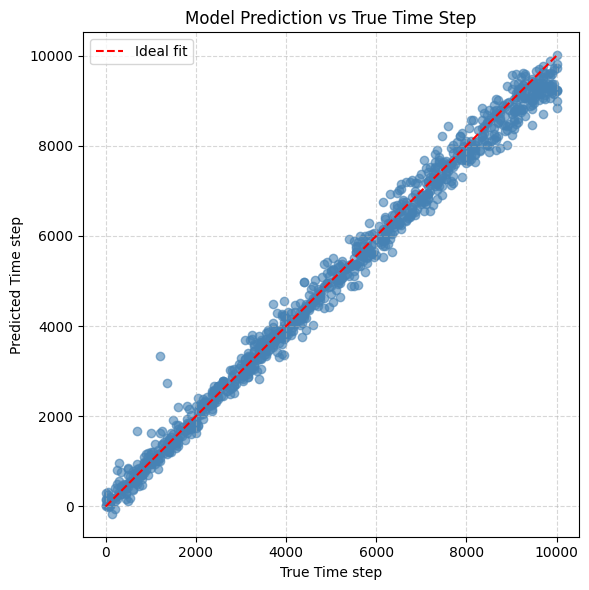

In [82]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_denorm[:, 2], y_pred_denorm[:, 2], alpha=0.6, color='steelblue')
plt.plot(
    [y_true_denorm[:, 2].min(), y_true_denorm[:, 2].max()],
    [y_true_denorm[:, 2].min(), y_true_denorm[:, 2].max()],
    'r--', label='Ideal fit'
)
plt.xlabel("True Time step")
plt.ylabel("Predicted Time step")
plt.title("Model Prediction vs True Time Step")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [83]:
df = pd.DataFrame({
    "True_Cr": y_true_denorm[:, 0],
    "Pred_Cr": y_pred_denorm[:, 0],
    "True_T": y_true_denorm[:, 1],
    "Pred_T": y_pred_denorm[:, 1]
})


<Axes: xlabel='True_Cr', ylabel='Pred_Cr'>

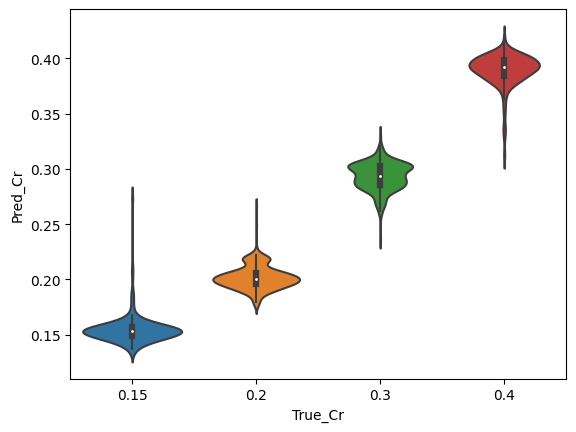

In [84]:
sns.violinplot(x="True_Cr", y="Pred_Cr", data=df)


<Axes: xlabel='True_T', ylabel='Pred_T'>

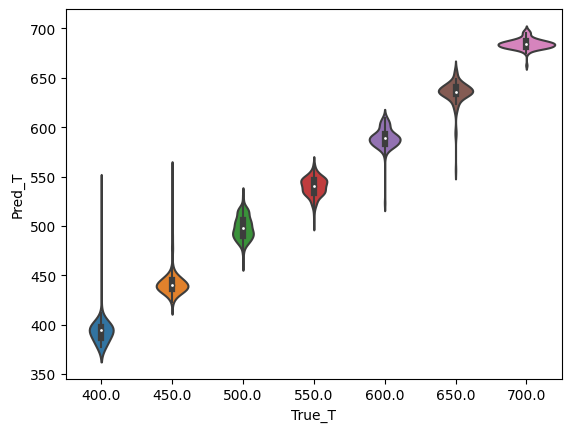

In [85]:
sns.violinplot(x="True_T", y="Pred_T", data=df)


Tensor shape: torch.Size([1, 64, 64])
Label (normalized): tensor([0.4000, 0.6000, 0.4000])


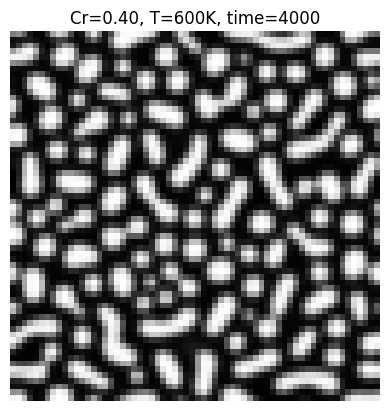

Predicted: Cr = 0.40, T = 591 K, Time = 3849


In [ ]:
#Data example
# Pick a random sample
img, label = test_ds[620]
print("Tensor shape:", img.shape)
print("Label (normalized):", label)

# Convert to NumPy for display
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title(f"Cr={label[0]*1:.2f}, T={label[1]*1000:.0f}K, time={label[2]*10000:.0f}")
plt.axis('off')
plt.show()

with torch.no_grad():
    pred = loaded_model(img.unsqueeze(0).to(device)).cpu().numpy()[0]

cr_pred = pred[0] * 1.0
T_pred = pred[1] * 1000.0
time_pred = pred[2] * 10000.0

print(f"Predicted: Cr = {cr_pred:.2f}, T = {T_pred:.0f} K, Time = {time_pred:.0f}")
